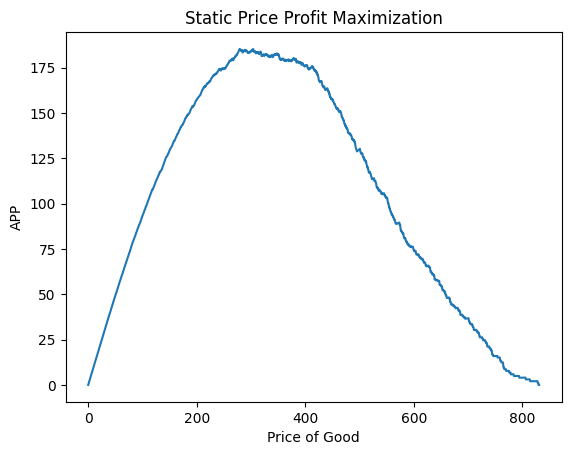

Optimized Static APP: 182.86
This represents the maximum average price per unit (APP) that can be  achieved using a static pricing strategy. Here, the price is fixed and does  not vary with demand or other factors.
Optimized Price: 279.16797110174593
This is the optimal static price that maximizes the APP.


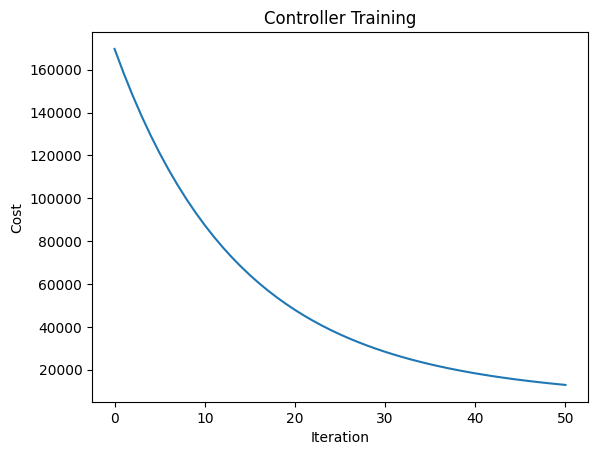

Optimized Weights:
Intercept: 131.2
Number_of_Riders: 0.7
Number_of_Drivers: 3.9
Number_of_Past_Rides: 3.0
Average_Ratings: -0.4
Expected_Ride_Duration: 95.7
Location_Category_Rural: 43.5
Location_Category_Suburban: 43.8
Location_Category_Urban: 45.1
Customer_Loyalty_Status_Gold: 42.2
Customer_Loyalty_Status_Regular: 42.8
Customer_Loyalty_Status_Silver: 47.8
Time_of_Booking_Afternoon: 32.5
Time_of_Booking_Evening: 30.6
Time_of_Booking_Morning: 33.9
Time_of_Booking_Night: 36.0
Vehicle_Type_Economy: 55.5
Vehicle_Type_Premium: 76.7
Optimized Weights:  [131.2   0.7   3.9   3.   -0.4  95.7  43.5  43.8  45.1  42.2  42.8  47.8
  32.5  30.6  33.9  36.   55.5  76.7]
Optimized Cost: 12903.16
This is the cost (or error) associated with the optimized weights on the training dataset. It represents the sum of squared differences between the predicted and actual historical costs of rides, divided by the number of observations.
Test Cost: 13827.03
This is the cost (or error) when the optimized model i

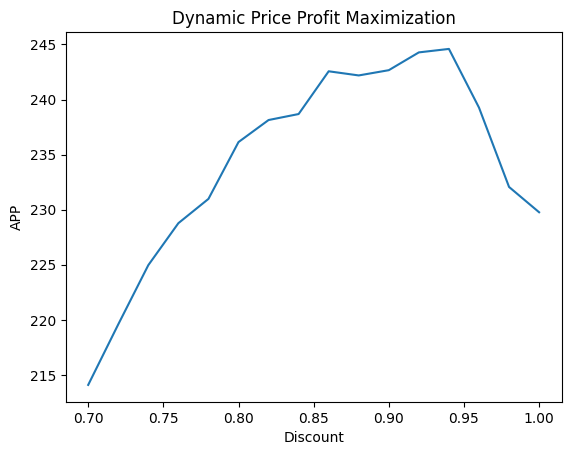

Optimized Discount: 0.94
Applying this discount factor helps to better align prices with what customers are willing to pay, maximizing demand and revenue.
Test Dynamic APP: 237.69
This is the average price per unit (APP) achieved using the dynamic pricing strategy with the optimized discount factor on the test dataset.
Dynamic APPU (Test-based): 237.69
Static APPU (Test-based): 182.86
Percentage in Profit Increase: 29.99%


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from autograd import value_and_grad
import matplotlib.pyplot as plt



df = pd.read_csv('dynamic_pricing.csv')
# Preprocessing
categorical_features = ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']
numerical_features = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 'Average_Ratings', 'Expected_Ride_Duration']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Apply the transformations to the dataframe
X = df.drop(columns=['Historical_Cost_of_Ride'])
y = df['Historical_Cost_of_Ride'].values
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data, transform the test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Add bias term (intercept) to the features
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Reshape for the model
X_train = X_train.T[np.newaxis, :]
X_test = X_test.T[np.newaxis, :]
y_train = y_train[np.newaxis, :]
y_test = y_test[np.newaxis, :]
# Model and cost function
def model(w, x):
    return np.dot(x[0].T, w)

def least_squares(w, x, y):
    cost = np.sum((model(w, x) - y) ** 2)
    return cost

def gradient_descent(g, alpha, max_its, w, x, y):
    gradient = value_and_grad(g)
    weight_history = []
    cost_history = []
    for k in range(1, max_its + 1):
        cost_eval, grad_eval = gradient(w, x, y)
        weight_history.append(w)
        cost_history.append(cost_eval)
        w = w - alpha * grad_eval
    weight_history.append(w)
    cost_history.append(g(w, x, y))
    cost_history = np.asarray(cost_history) / x.shape[2]
    return weight_history, cost_history
    # Training the model
rate = 1e-5
max_it = 50
initial_weights = np.random.rand(X_train.shape[1])
wh, ch = gradient_descent(least_squares, rate, max_it, initial_weights, X_train, y_train)

# Finding the best weights
index = np.argmin(ch)
w_star = wh[index]
# Evaluating the model
cost_train = ch[index]
cost_test = least_squares(w_star, X_test, y_test) / X_test.shape[2]


# Calculate APP for static and dynamic pricing
def demand_curve(axis, value):
    demand = []
    sample_size = len(value)
    for price in axis:
        demand.append(sum(1 if x >= price else 0 for x in value) / sample_size)
    return demand

def APP_s(axis, value, c):
    demand = demand_curve(axis, value)
    app_s = []
    for i in range(len(axis)):
        app_s.append(max(axis[i] - c, 0) * demand[i])
    return app_s

def APP_d(w, x, y, c, d):
    est = d * model(w, x)
    ind = list(range(len(est)))
    rev = sum(max(est[i], c) if y[0][i] >= max(est[i], c) else 0 for i in ind)
    return rev / x.shape[2]

c = 0  # Assuming cost is 0 for simplicity
axis_2 = np.linspace(0, int(np.round(np.max(y_train), 0) + 1), int(2 * (np.round(np.max(y_train), 0) + 1)))
app_s_train = APP_s(axis_2, y_train[0], c)
index = np.argmax(app_s_train)
app_s_test = APP_s(axis_2, y_test[0], c)
app_s_star = app_s_test[index]
plt.figure()
plt.plot(axis_2, app_s_train)
plt.xlabel('Price of Good')
plt.ylabel('APP')
plt.title('Static Price Profit Maximization')
plt.show()


print('Optimized Static APP: {:.2f}'.format(app_s_star))
print ('This represents the maximum average price per unit (APP) that can be '
' achieved using a static pricing strategy. Here, the price is fixed and does '
' not vary with demand or other factors.')
print('Optimized Price:', axis_2[index])
print('This is the optimal static price that maximizes the APP.')
plt.figure()
plt.plot(range(max_it + 1), ch)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Controller Training')
plt.show()

# Get column names after transformation
categorical_transformer = preprocessor.transformers_[1][1]  # Get the OneHotEncoder from the ColumnTransformer

# Get feature names from OneHotEncoder
feature_names_categorical = list(categorical_transformer.get_feature_names_out(input_features=categorical_features))

# Combine feature names
feature_names = numerical_features + feature_names_categorical

# Add Intercept to feature names
feature_names = ['Intercept'] + feature_names

# Print optimized weights with feature names
print('Optimized Weights:')
for feature, weight in zip(feature_names, np.round(w_star, 1)):
    print(f'{feature}: {weight}')

print('Optimized Weights: ', np.round(w_star, 1))
print('Optimized Cost: {:.2f}'.format(cost_train))
print('This is the cost (or error) associated with the optimized weights on the'
      ' training dataset. It represents the sum of squared differences between '
      'the predicted and actual historical costs of rides, divided by the '
      'number of observations.')
print('Test Cost: {:.2f}'.format(cost_test))
print('This is the cost (or error) when the optimized model is applied to the'
      ' test dataset. The slightly higher test cost compared to the training '
      'cost indicates how well the model generalizes to unseen data.')

app_d_1 = APP_d(w_star, X_test, y_test, c, 1)
print('Dynamic APP: {:.2f}'.format(app_d_1))
print('This is the average price per unit (APP) achieved using the dynamic '
'pricing strategy without any discount.')
axis_d = np.linspace(0.7, 1, 16)
app_d = [APP_d(w_star, X_test, yw_test, c, d) for d in axis_d]

d_star = axis_d[np.argmax(app_d)]
app_d_star = APP_d(w_star, X_train, y_train, c, d_star)



plt.figure()
plt.plot(axis_d, app_d)
plt.xlabel('Discount')
plt.ylabel('APP')
plt.title('Dynamic Price Profit Maximization')
plt.show()


print('Optimized Discount: {:.2f}'.format(d_star))
print('Applying this discount factor helps to better align prices with what '
'customers are willing to pay, maximizing demand and revenue.')
print('Test Dynamic APP: {:.2f}'.format(app_d_star))
print('This is the average price per unit (APP) achieved using the dynamic '
'pricing strategy with the optimized discount factor on the test dataset.')
print('Dynamic APPU (Test-based): {:.2f}'.format(app_d_star))
print('Static APPU (Test-based): {:.2f}'.format(app_s_star))
print('Percentage in Profit Increase: {:.2%}'.format((app_d_star - app_s_star) / app_s_star))
